# Some lessons on working with real world data: APIs and data wrangling

In [1]:
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start to work towards being able
to grab data on the fly from the USGS website. And now we've defined
the site id for the Verde River, as well as some start and end dates
to get the data for. With those defined clearly it makes it much
easier for someone else to understand what you are trying to do.

In [3]:
args = {
    'site_no': '09506000',
    'begin_date': '2021-09-25',
    'end_date': '2022-09-25'
}
query = urllib.parse.urlencode(args)

In [4]:
query

'site_no=09506000&begin_date=2021-09-25&end_date=2022-09-25'

Now we can use f-strings to insert these values into the query URL
which will point to the same website that we saw in the lecture portion
You can verify this by copying the URL into your web browser.

In [6]:
verde_url = (
    f'https://nwis.waterdata.usgs.gov/usa/nwis/dv/?'
    f'cb_00060=on&format=rdb&referred_module=sw&{query}'

)
print(verde_url)

https://nwis.waterdata.usgs.gov/usa/nwis/dv/?cb_00060=on&format=rdb&referred_module=sw&site_no=09506000&begin_date=2021-09-25&end_date=2022-09-25


With that we need to download the data and get it into pandas.
To download the data we'll use the `urllib` module which is 
built into the python "standard library" of stuff you get for
free when you install python. We use the `urllib.request.urlopen`
function which simply opens a connection to the url, just like 
going to the url in your web browser. Then, we can put the `response`
into `pd.read_table`. There are a lot of other parameters going 
into this function now, and this is very common for when you scrape
data directly from the internet because formats vary.

Anyways, let's walk through a few of them:
 - comment='#': Lines beginning with a '#' are comments that pandas should ignore
 - skipfooter=1: Skip the last line, not including this leads to no data ¯\_( ツ )_/¯
 - sep='\s+': The separator is whitespace (one or more spaces) - this is a regular expression (or regex)
 - names: The names of the columns. I set these because the USGS ones are trash
 - index_col=2: Set the 3rd column as the index (that is, "date")

In [10]:
response = urllib.request.urlopen(verde_url)
print (response)

In [11]:

df = pd.read_table(
    response,
    comment='#',
    skipfooter=1,
    sep='\t',
    names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
    index_col=2,
    engine='python'
).iloc[2:]
df.index = pd.DatetimeIndex(df.index)

In [13]:
df.head()

,agency,site,streamflow,quality_flag
date,,,,
2021-09-25,USGS,09506000,83.7,A
2021-09-26,USGS,09506000,106.0,A
2021-09-27,USGS,09506000,160.0,A
2021-09-28,USGS,09506000,183.0,A
2021-09-29,USGS,09506000,187.0,A


Now convert the streamflow data to floats and
the index to datetimes. When processing raw data
it's common to have to do some extra postprocessing

In [14]:
df['streamflow'] = df['streamflow'].astype(np.float64)
df.index = pd.DatetimeIndex(df.index)
df.head()

,agency,site,streamflow,quality_flag
date,,,,
2021-09-25,USGS,09506000,83.7,A
2021-09-26,USGS,09506000,106.0,A
2021-09-27,USGS,09506000,160.0,A
2021-09-28,USGS,09506000,183.0,A
2021-09-29,USGS,09506000,187.0,A


And voila - we have a nice dataframe with streamflow data in it
You can do all of the standard pandas stuff

Text(0.5, 1.0, 'graph')

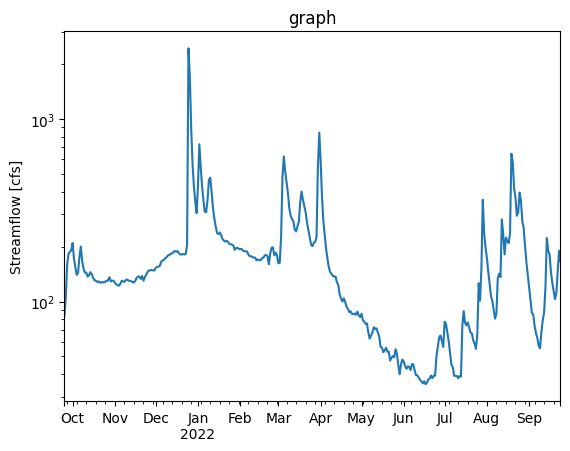

In [16]:
df['streamflow'].plot()
plt.semilogy()
plt.ylabel('Streamflow [cfs]')
plt.xlabel('')
plt.title('graph')

Now, you might be thinking... why only one year of data?!
And that's a great question. Before getting too far, let's
just turn our little data processing things into some helper
functions to save space, and make this easier for you to port
to your homework

In [17]:
def create_usgs_url(site_no, begin_date, end_date):
    return (
        f'https://nwis.waterdata.usgs.gov/usa/nwis/dv/?'
        f'cb_00060=on&format=rdb&referred_module=sw&'
        f'site_no={site_no}&'
        f'begin_date={begin_date}&'
        f'end_date={end_date}'
    )

def open_usgs_data(site, begin_date, end_date):
    url = create_usgs_url((site), begin_date, end_date)
    response = urllib.request.urlopen(url)
    df = pd.read_table(
        response,
        comment='#',
        skipfooter=1,
        sep='\t',
        names=['agency', 'site', 'date', 'streamflow', 'quality_flag'],
        index_col=2,
        engine='python'
    ).iloc[2:]

    # Now convert the streamflow data to floats and
    # the index to datetimes. When processing raw data
    # it's common to have to do some extra postprocessing
    df['streamflow'] = df['streamflow'].astype(np.float64)
    df.index = pd.DatetimeIndex(df.index)
    return df

Text(0.5, 0, '')

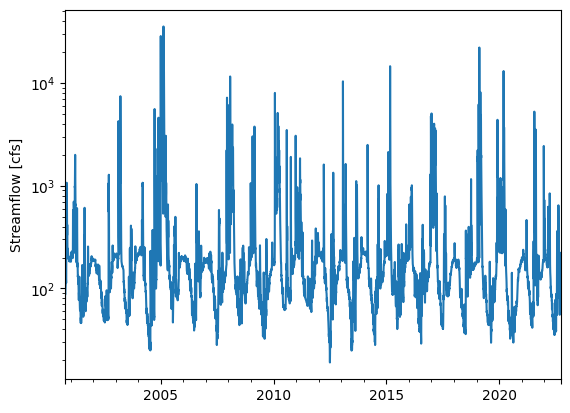

In [18]:
site = '09506000'
begin_date = '2000-09-25'
end_date = '2022-09-25'

df = open_usgs_data(site, begin_date, end_date)
df['streamflow'].plot()
plt.semilogy()
plt.ylabel('Streamflow [cfs]')
plt.xlabel('')

Hmm, 20 years of daily data starts to blend together.
Just a quick aside on another nice feature of pandas, the resample
Let's just resample the data down to monthly means like so:

In [37]:
df.index

DatetimeIndex(['2000-09-25', '2000-09-26', '2000-09-27', '2000-09-28',
               '2000-09-29', '2000-09-30', '2000-10-01', '2000-10-02',
               '2000-10-03', '2000-10-04',
               ...
               '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18',
               '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22',
               '2022-09-23', '2022-09-24'],
              dtype='datetime64[ns]', name='date', length=8035, freq=None)

Text(0.5, 0, '')

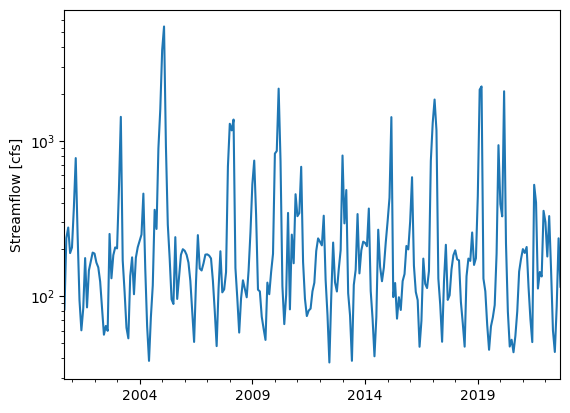

In [38]:
df['streamflow'].resample('M').mean().plot()
plt.semilogy()
plt.ylabel('Streamflow [cfs]')
plt.xlabel('')

Now, let's look at some DayMet data. 
Before that, let me explain...

DayMet actually has a really nice interactive
API explorer that you can use to prototype:
- https://daymet.ornl.gov/single-pixel/api

In [19]:
url = "https://daymet.ornl.gov/single-pixel/api/data?lat=34.9455&lon=-113.2549"  \
       "&vars=prcp&start=1984-08-14&end=2014-10-18&format=json"
url

'https://daymet.ornl.gov/single-pixel/api/data?lat=34.9455&lon=-113.2549&vars=prcp&start=1984-08-14&end=2014-10-18&format=json'

In [20]:
begin_date = '2000-09-20'
end_date = '2020-09-25'
args = {
    'lat':  34.4483605,
    'lon': -111.7898705,
    'start': begin_date,
    'end': end_date,
    'vars': ['prcp', 'Tmax', 'Tmin'],
    'format': 'csv'
}
query = urllib.parse.urlencode(args)
url = f"https://daymet.ornl.gov/single-pixel/api/data?{query}"
url

'https://daymet.ornl.gov/single-pixel/api/data?lat=34.4483605&lon=-111.7898705&start=2000-09-20&end=2020-09-25&vars=%5B%27prcp%27%2C+%27Tmax%27%2C+%27Tmin%27%5D&format=csv'

In [21]:
response = urllib.request.urlopen(url)
daymet_df = pd.read_csv(response, header=6)
daymet_df.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa)
0,2000,264,43133.96,0.0,440.31,0.0,36.56,14.95,1315.16
1,2000,265,43001.01,0.0,347.65,0.0,32.41,17.09,1692.53
2,2000,266,42868.10,0.0,310.08,0.0,30.70,17.40,1776.14
3,2000,267,42735.24,0.0,281.34,0.0,29.46,17.50,1868.06
4,2000,268,42602.47,0.0,436.81,0.0,31.15,10.49,958.68


Daymet is annoying in that it only reports the year
and day of year, rather than real dates. Also it uses
a no-leap calendar, meaning all years have 365 days.
So now our goal is to convert the `year` and `yday`
columns into proper date times. This one took me a 
second to figure out, but some quick googling got 
me there:
https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas

In [22]:
datestring = (daymet_df['year'].astype(str) 
              + daymet_df['yday'].astype(str))
datestring.head()

0    2000264
1    2000265
2    2000266
3    2000267
4    2000268
dtype: object

And we can pass that directly into the `pd.to_datetime` 
function, with a format of `%Y%j` which means YEAR followed
by the Julian day (AKA day of year)

In [23]:
dates = pd.to_datetime(datestring, format='%Y%j')
daymet_df.index = pd.DatetimeIndex(dates)
daymet_df.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa)
2000-09-20,2000,264,43133.96,0.0,440.31,0.0,36.56,14.95,1315.16
2000-09-21,2000,265,43001.01,0.0,347.65,0.0,32.41,17.09,1692.53
2000-09-22,2000,266,42868.10,0.0,310.08,0.0,30.70,17.40,1776.14
2000-09-23,2000,267,42735.24,0.0,281.34,0.0,29.46,17.50,1868.06
2000-09-24,2000,268,42602.47,0.0,436.81,0.0,31.15,10.49,958.68


With the dates correct, we now can merge things together
Just one last minor hickup, the lack of leap years in
daymet means we have to reindex to the dates from the 
USGS database. Finally, for shorthand I just rename the whole thing `df`.

In [24]:
verde_df = open_usgs_data(site, begin_date, end_date)
daymet_df = daymet_df.reindex(verde_df.index)
daymet_df['streamflow'] = verde_df['streamflow']
df = daymet_df

KeyboardInterrupt: 

And now we can do some comparisons!

[]

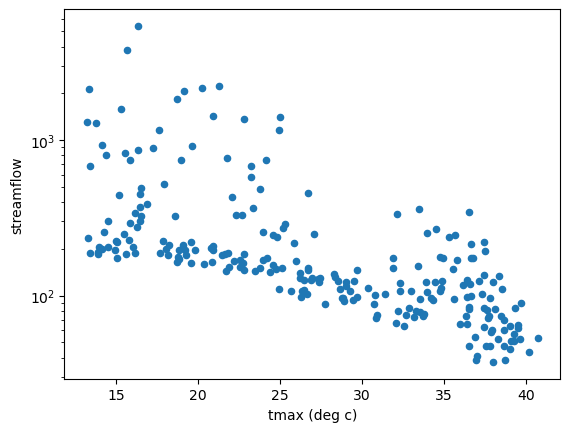

In [45]:
df_monthly = df.resample('M').mean()
df_monthly.plot.scatter(x='tmax (deg c)', y='streamflow')
plt.semilogy()